<a href="https://colab.research.google.com/github/GermanOmar/LaserVWC/blob/master/LaserWelding1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanical vibration effect over the microhardness of AISI A36 steel in a lap configuration joints by laser welding


<a href="https://ibb.co/VH5s6tP"><img src="https://i.ibb.co/PT0dkNf/LaserVWC.png" WIDTH="420" HEIGHT="300"  border="0"></a>

 Libraries

In [54]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

 Upload database:

In [55]:
!git clone https://github.com/GermanOmar/LaserVWC

fatal: destination path 'LaserVWC' already exists and is not an empty directory.


In [56]:
#Experimental data
data = pd.read_table('Df.txt') 
data.describe()


,Amplitude,Frequency,Hardness
count,44.000000,44.000000,44.000000
mean,0.394545,523.401818,167.522727
std,0.131847,379.779496,13.599741
min,0.200000,0.000000,143.000000
25%,0.280000,210.082500,158.500000
50%,0.400000,585.690000,169.000000
75%,0.480000,831.985000,177.250000
max,0.560000,1034.510000,197.000000


<a href="https://ibb.co/cgFcLwg"><img src="https://i.ibb.co/JB7RQqB/Contour-Plot.png" WIDTH="500" HEIGHT="325"  border="0"></a>


Setting inputs - output:

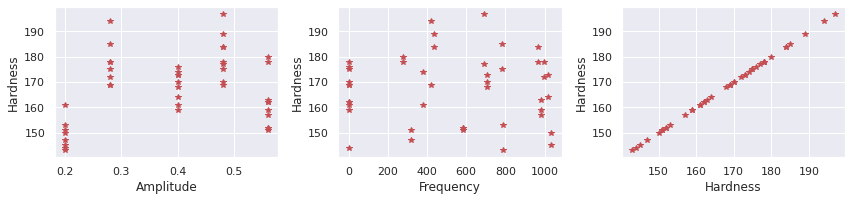

In [57]:
fields = [ 'Amplitude',  'Frequency','Hardness']
import seaborn as sns
sns.set()

fig = plt.figure()
fig.set_size_inches((12,8))
for i, field in enumerate(fields):
  plt.subplot(3, 3, i + 1)
  plt.plot(data[field], data['Hardness'], 'r*')
  plt.xlabel(field)
  plt.ylabel('Hardness')

plt.tight_layout()

X=data[[ 'Amplitude',  'Frequency']]
Y=data['Hardness'][:,None]


#fig.tight_layout()

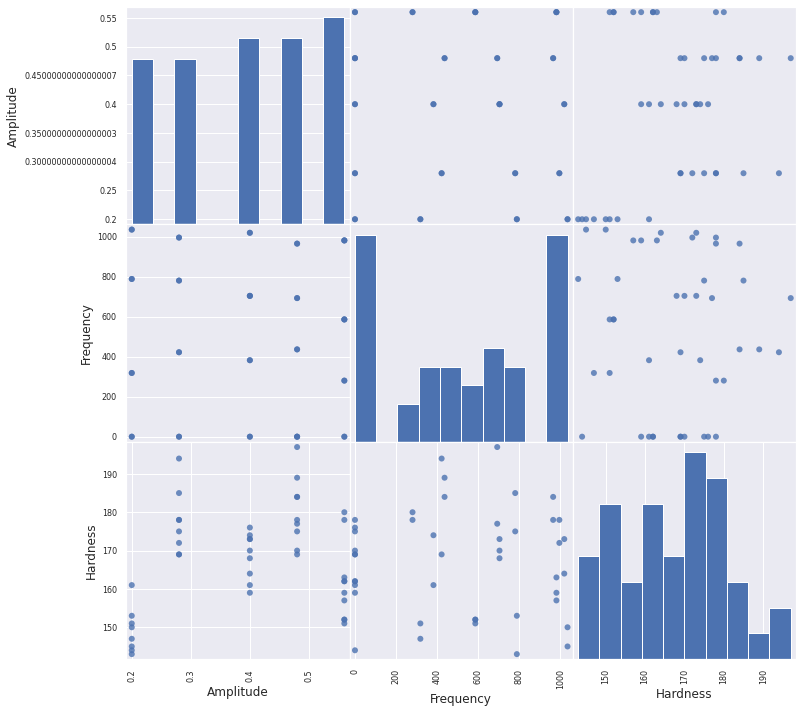

In [ ]:
from pandas.plotting import scatter_matrix

#DISPLAY MATRIX - identificar correlacion entre variables
scatter_matrix(data, alpha=0.8, marker='o', figsize = (12,12))

import warnings
warnings.filterwarnings("ignore")

Normalizing


In [ ]:
def normalize(X, X_mu, X_std):
  return (X - X_mu)/X_std

def denormalize(Xn, X_mu, X_std):
  return Xn*X_std + X_mu

X_std = X.std(0)
X_mu = X.mean(0)
Xn = normalize(X, X_mu, X_std)

Y_std = Y.std(0)
Y_mu = Y.mean(0)
Yn = normalize(Y, Y_mu, Y_std)

 Split data

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 35  test samples: 9


In [33]:
X_test



,Amplitude,Frequency
29,0.48,436.08
17,0.40,0.00
33,0.48,964.48
40,0.56,585.69
8,0.28,0.00
13,0.28,779.86
4,0.20,787.82
20,0.40,703.46
10,0.28,421.76


#Results:

###GBR 

In [59]:
from sklearn.ensemble import GradientBoostingRegressor
#KERNEL
#GBR=GradientBoostingRegressor(n_estimators=100, random_state=0)
GBR=GradientBoostingRegressor(n_estimators=2000, random_state=42, learning_rate=0.1 )

#START TRAINING
GBR.fit(X_train,y_train)
#PREDICTION
y_pred=GBR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

 
print("-Gradient boosting regressor-")
print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()


-Gradient boosting regressor-
-----------------------------
MSE test: 108.20880807617124

R2:  0.4084156685900465
RMSE:  10.402346277459294
MAE:  8.724278109494511
IM:  13.589400598596914



### GPs

In [60]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
 
GP=GPR(kernel=kernel, n_restarts_optimizer=20, alpha=0.01, normalize_y=True)
 
#Training
GP.fit(X_train,y_train)
 
#Testing
y_star_train = GP.predict(X_train)
y_pred = GP.predict(X_test)
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Gaussian Process")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)
print()
""" 
RE=100 * abs(y_test - y_pred) / y_test
print('Relative error (%): ',RE)
"""
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 
#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

Gaussian Process
MSE train: 28.19523830065595
MSE test: 74.41399545417636
MSE train < MSE test? True

R2_train:  0.8432887163416354
R2_test:  0.593174025932216

R2:  0.593174025932216
RMSE:  8.626354702548253
MAE:  7.547861872120399
IM:  11.469512704032436



### RFR

In [61]:
from sklearn.ensemble import RandomForestRegressor
#KERNEL
RFR=RandomForestRegressor(n_estimators=2000,max_depth=20)

#START TRAINING
RFR.fit(X_train,y_train)
#PREDICTION
y_pred=RFR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-----------------------------
MSE test: 131.8978724955544

R2:  0.27890606964498466
RMSE:  11.4846799039222
MAE:  9.686354982363317
IM:  15.041386963850904



### XGB

In [62]:
import pickle
import xgboost as xgb

xgbr = xgb.XGBRegressor(verbosity=0, n_estimators=2000, max_depth=20)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

In [63]:
print(xgbr)



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)


In [64]:
score = xgbr.score(X_test, y_test)  
print("Training score: ", score)

Training score:  0.3962876216034992


In [65]:
print("-XGBRegressor -")
print("------------------")

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-XGBRegressor -
------------------
MSE test: 110.4271925718834

R2:  0.3962876216034992
RMSE:  10.508434353978874
MAE:  8.789116753472221
IM:  13.712776324066496



### AdaBoost

In [66]:
from sklearn.ensemble import AdaBoostRegressor

print(" AdaBoost -")
print("------------------")

Ada = AdaBoostRegressor(random_state=42, n_estimators=2000)
#START TRAINING
Ada.fit(X_train,y_train)
#PREDICTION
y_pred=Ada.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

 AdaBoost -
------------------
MSE test: 112.56790123456791

R2:  0.38458423326133895
RMSE:  10.609802129849921
MAE:  9.037037037037038
IM:  13.950436416445816



### MLP

In [67]:
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(hidden_layer_sizes=8,solver='lbfgs',learning_rate='adaptive',activation='relu',random_state=42, max_iter=2000)
#MLP = MLPRegressor(hidden_layer_sizes=(1000,1000,1000), activation='relu', solver='adam', max_iter=800)

#START TRAINING
MLP.fit(X_train,y_train)
#PREDICTION
y_pred=MLP.predict(X_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()



R2:  -0.0677487130179466
RMSE:  10.609802129849921
MAE:  11.573943039158898
IM:  15.737348760906778



# Comparisson

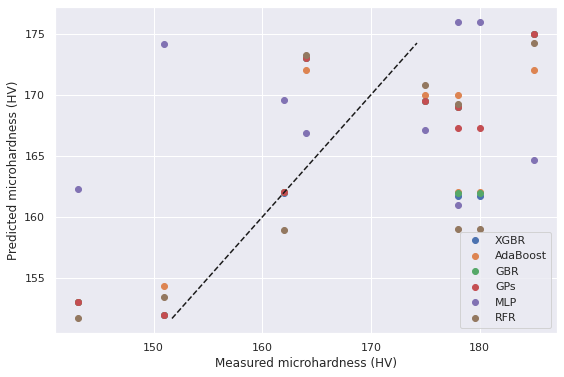

In [81]:
models = [xgbr, Ada, GBR,  GP, MLP, RFR ]
labels = ['XGBR', 'AdaBoost', 'GBR',   'GPs',  'MLP', 'RFR']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X_test)
  plt.plot(y_test, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('Predicted microhardness (HV)')
plt.xlabel('Measured microhardness (HV)')
plt.legend()

# CROSS-VALIDATION

In [69]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import cross_val_score as CV

import warnings
warnings.filterwarnings('ignore')

models = [xgbr, Ada, GBR,  GP,  MLP, RFR ]
labels = ['XGBR', 'AdaBoost', 'GBR',   'GPs',  'MLP', 'RFR']
IMS = []

print("--------------------------------------------------------------")
print("%5s | %5s | %5s | %5s | %5s " % ("ML algorithm",  "CV-R2", "CV-MSE", "CV-MAE", "IM"))
print("--------------------------------------------------------------")

for mod, label in zip( models, labels): 
  y_star_train = mod.predict(X_train)
 
  scoreR2 = CV(mod, X_train, y_train, cv=5, scoring='r2')
  #print(-1*scoreR2)
  scoreMSE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
  #print(-1*scoreMSE)
  scoreMAE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
  #print(-1*scoreMAE)
  IM=np.sqrt(((1-scoreR2)**2) + (scoreMSE) + (scoreMAE**2) )
  #print("IM: ", IM)
  
 
  print("%15s | %.4f | %.4f | %.4f | %.4f " % (label,  scoreR2.mean(), -1*scoreMSE.mean(), -1*scoreMAE.mean() , np.sqrt(((1-scoreR2.mean())**2) + (-1*scoreMSE.mean()) + (scoreMAE.mean()**2) )))
print("--------------------------------------------------------------")

--------------------------------------------------------------
ML algorithm | CV-R2 | CV-MSE | CV-MAE |    IM 
--------------------------------------------------------------
           XGBR | -0.2220 | 117.2936 | 8.1509 | 13.6097 
       AdaBoost | 0.1686 | 94.2060 | 7.1857 | 12.1050 
            GBR | -0.1942 | 117.4692 | 8.1112 | 13.5899 
            GPs | -0.2009 | 139.9369 | 9.0633 | 14.9507 
            MLP | -0.7235 | 208.4679 | 12.4515 | 19.1436 
            RFR | 0.2110 | 81.6723 | 7.1417 | 11.5455 
--------------------------------------------------------------


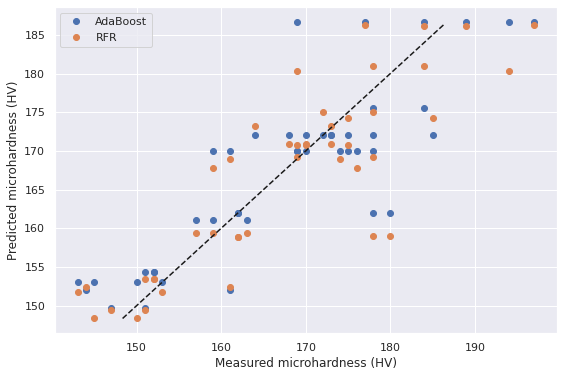

In [82]:
models = [Ada,  RFR ]
labels = [ 'AdaBoost','RFR']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X)
  plt.plot(Y, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('Predicted microhardness (HV)')
plt.xlabel('Measured microhardness (HV)')
plt.legend()

## Predictions:

In [71]:
X_test


,Amplitude,Frequency
37,0.56,280.11
24,0.40,1018.59
25,0.48,0.00
36,0.56,280.11
34,0.56,0.00
40,0.56,585.69
4,0.20,787.82
12,0.28,779.86
8,0.28,0.00


In [72]:
X04=([[ 0.4,	0.0]])
HV=RFR.predict(X04)

In [73]:
HV

array([167.76929762])

In [74]:
#independet variables
fa=pd.read_table('eval.txt', header=None)

In [75]:
#dependet variables
hv=pd.read_table('evalHV.txt', header=None)

In [86]:
hv

,0
0,151.749988
1,152.478944
2,152.223533
3,153.147124
4,168.532470
5,175.260514
6,180.385649
7,171.916317
8,163.542011
9,167.753962


In [89]:
RFpred=(RFR.predict(fa))


In [77]:
RFpred


array([152.3375619 , 149.45579643, 151.6890744 , 148.33034226,
       169.26722857, 180.34412619, 174.22687302, 175.01097143,
       167.76929762, 168.99398274, 170.9455998 , 173.27612321,
       170.75767857, 186.12047798, 186.30079167, 181.0098369 ,
       158.9190131 , 159.02780357, 153.43839762, 159.44511032])

In [90]:

ADApred=Ada.predict(fa)

In [91]:
ADApred

array([152.        , 149.66666667, 153.        , 153.        ,
       170.        , 186.66666667, 172.        , 172.        ,
       170.        , 170.        , 172.        , 172.        ,
       170.        , 186.66666667, 186.66666667, 175.57142857,
       162.        , 162.        , 154.33333333, 161.        ])

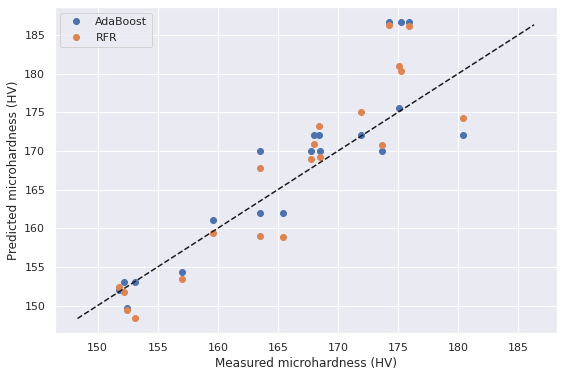

In [93]:
models = [Ada,  RFR ]
labels = [ 'AdaBoost','RFR']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(fa)
  plt.plot(hv, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('Predicted microhardness (HV)')
plt.xlabel('Measured microhardness (HV)')
plt.legend()